# RAG Fusion

In the following notebook, we will implement RAG fusion, which is a new take on traditional RAG.

It was introduced as part of the following paper:
[RAG Fusion](https://arxiv.org/pdf/2402.03367)





## RAG vs RAG Fusion


### Traditional RAG



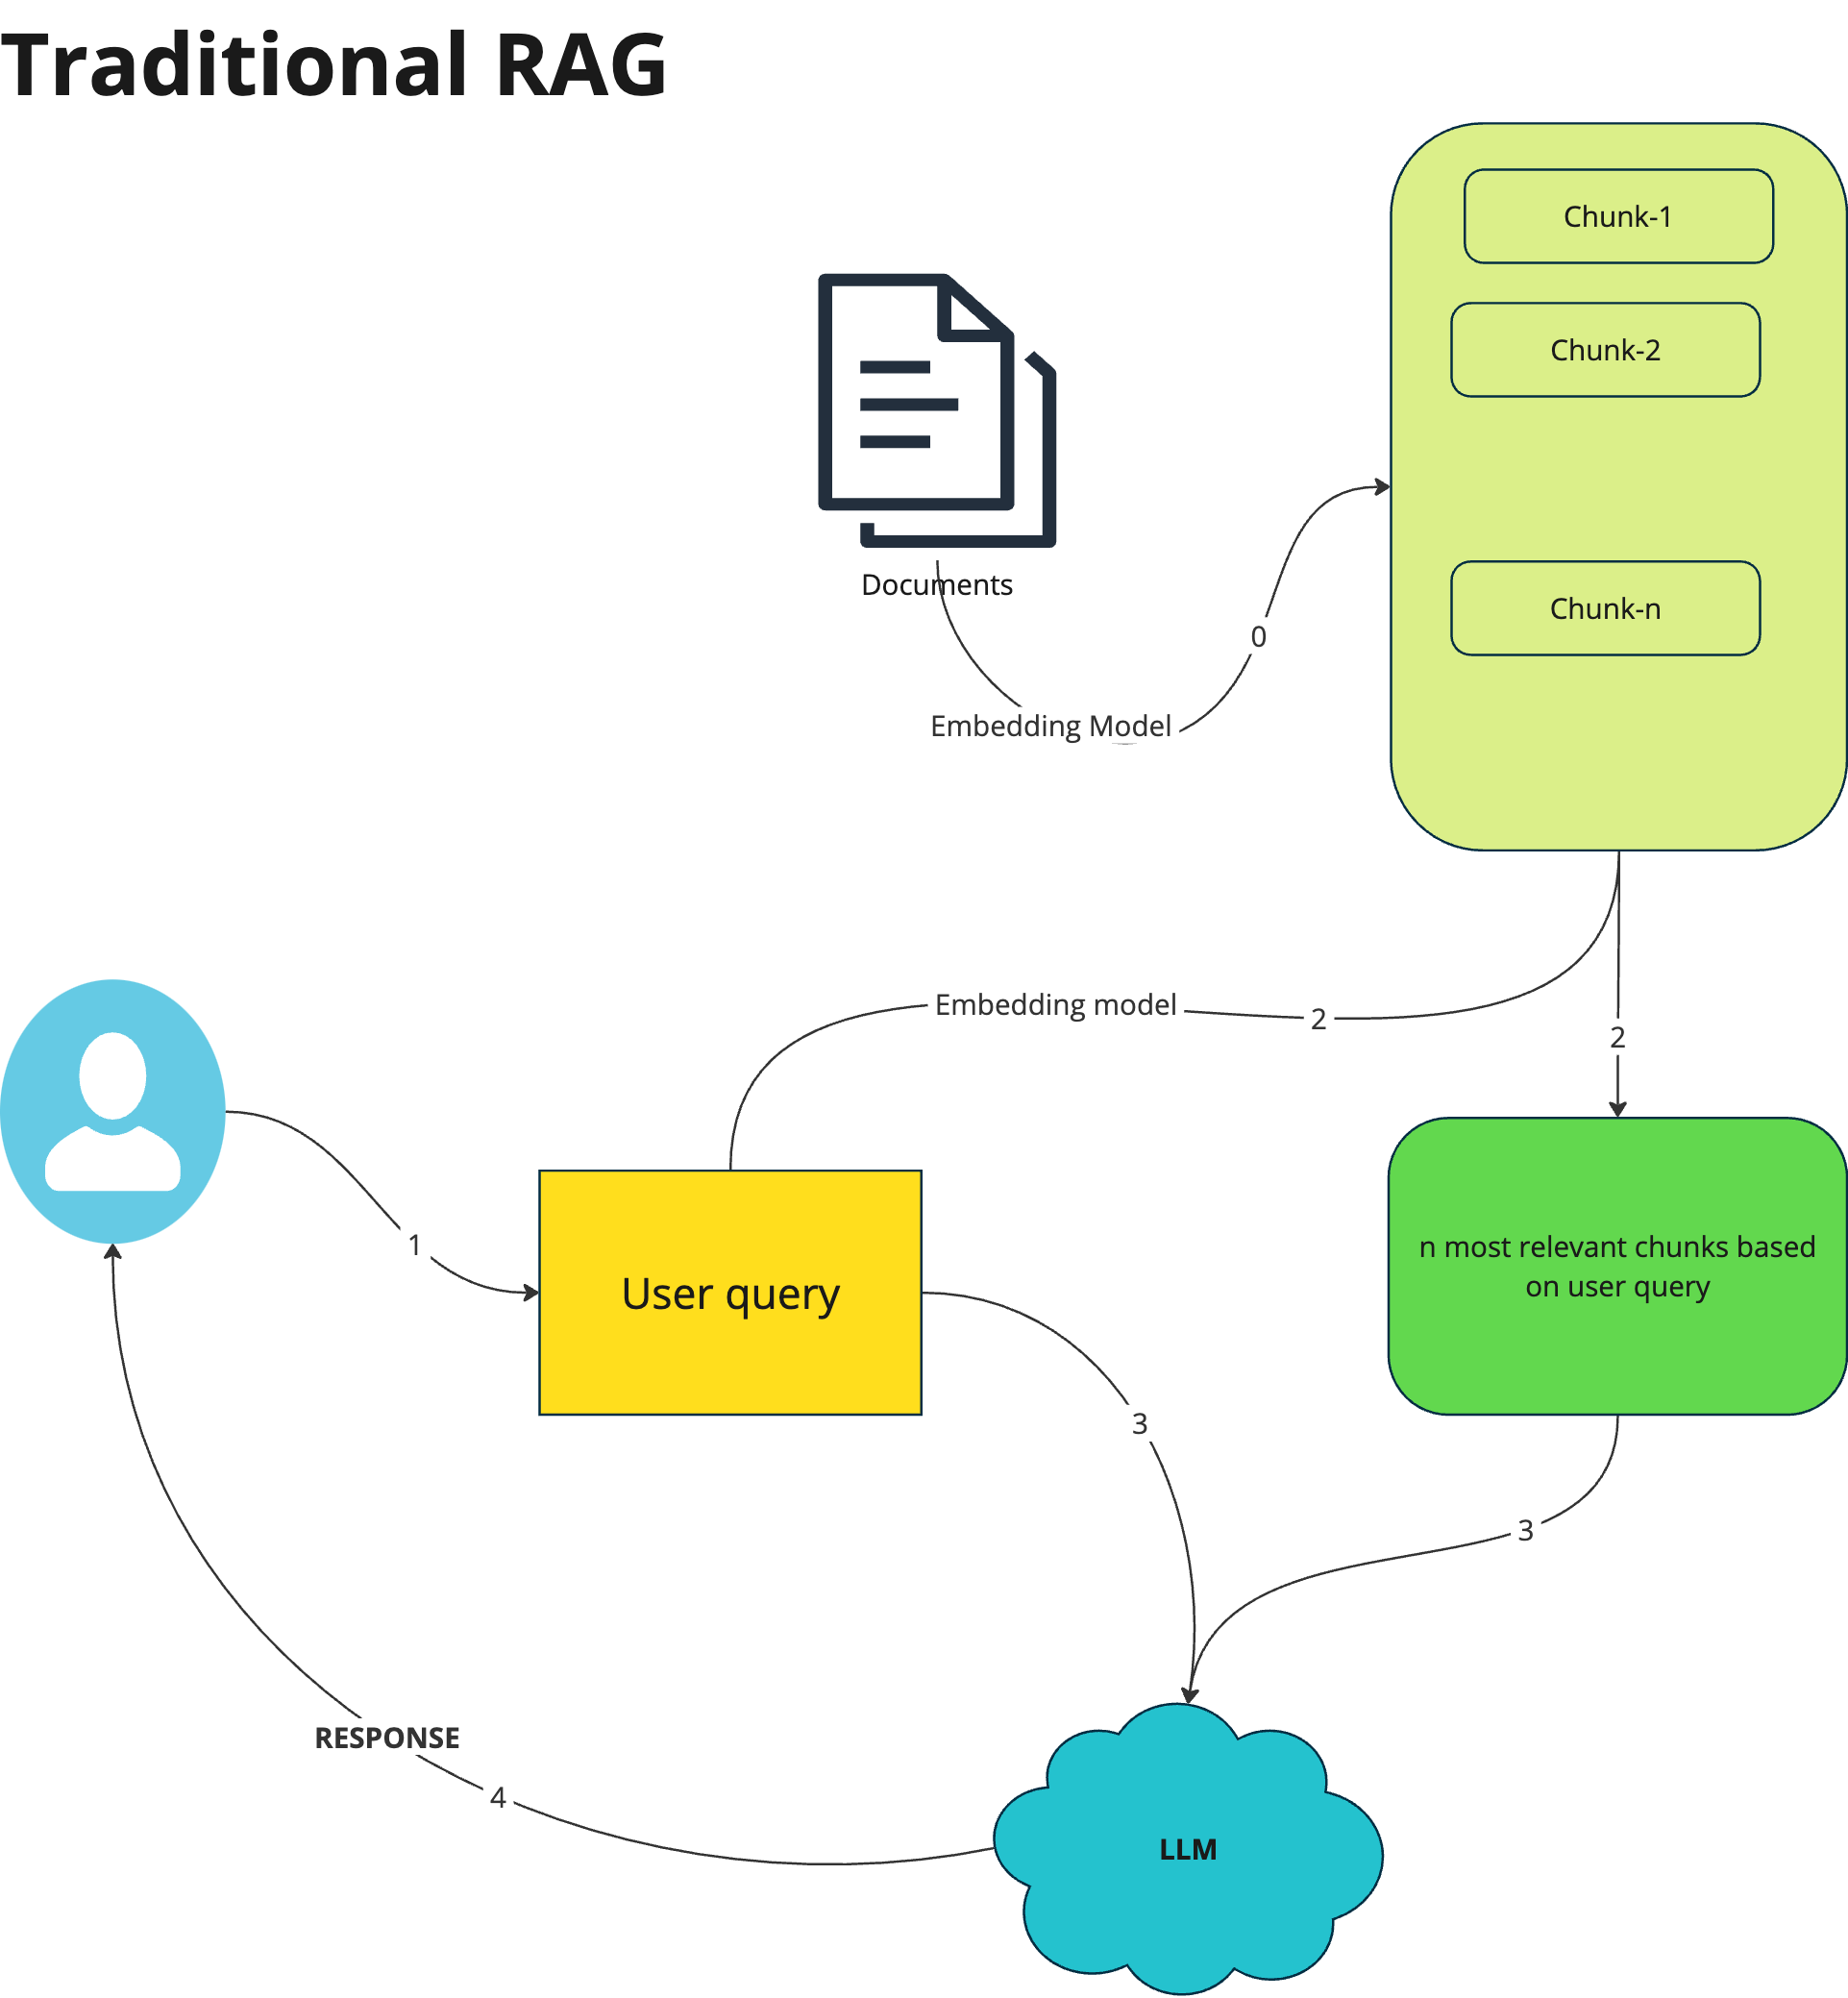

The traditional retrieval-augmented generation chatbot model for specific product information consists of the following
steps:


*   Gather product documents (e.g., datasheets, and product selection guides) in a database of documents for
retrieval into text.
*   Create vector embeddings and store them in a vector database.

Upon receiving a query from the user,
* Retrieve the n most relevant documents based on vector distance to the original query via vector search.
* Send the query together with the retrieved documents to a large language model to generate a response and
output the response.


### RAG Fusion

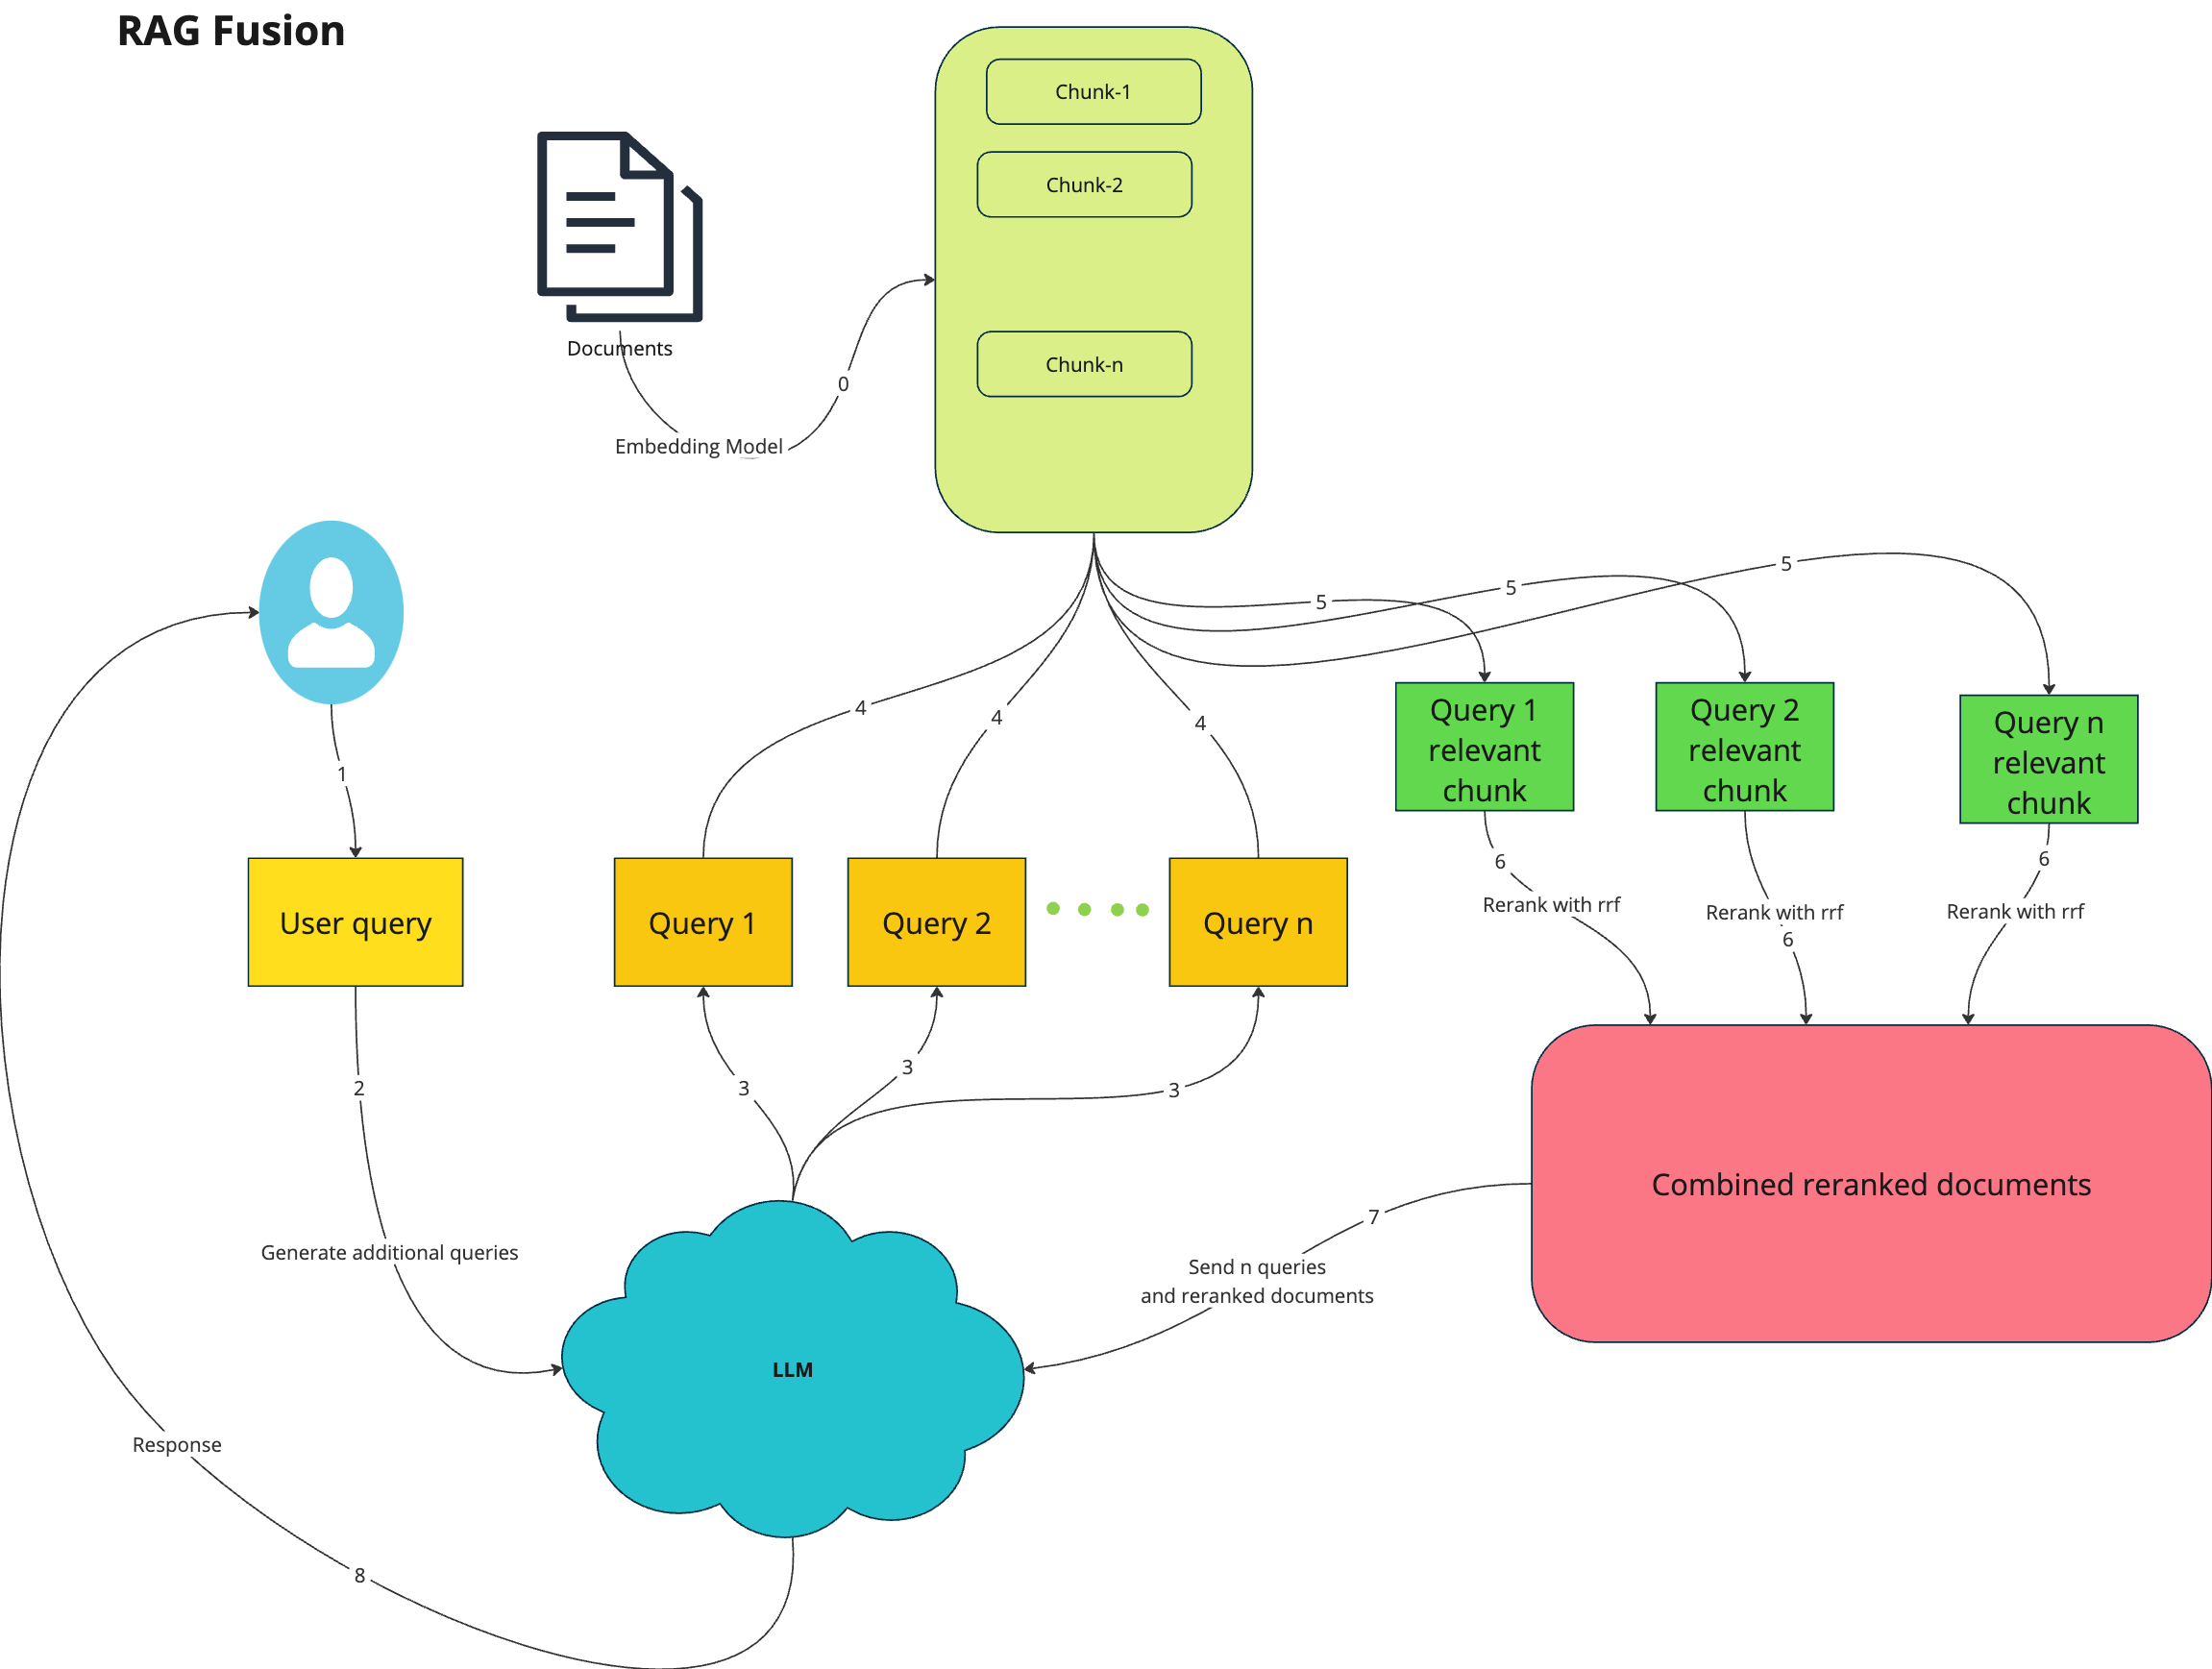

RAG-Fusion, on the other hand, has a few extra steps. Once the original query is received, the model sends the
original query to the large language model to generate a number of new search queries based on the original query.

The algorithm then performs vector search to find a number of relevant documents like with RAG. But, instead of
sending those documents with the queries to the large language model to generate the output, the model performs
reciprocal rank fusion.

Upon each calculation of the score, the rrf score is accumulated with previous
scores for the same document, and when all scores are accumulated, documents are fused together and reranked
according to their scores. The model then sends the reranked results along with the generated queries and the original
queries to the large language model to produce an output.

## Next steps



1. Gather dependencies  
2. Load documents
3. Setup vector DB (QDrant)
4.   Implement traditional RAG
5. Implement RAG fusion
6. Perform vibe check evaluation



### Gather dependencies

In [94]:
!pip install -qU langchain langchain-openai qdrant-client langchain_community pandas ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.6 MB/s eta 0:00:00


In [2]:
#Keys:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

Enter your OpenAI API Key:··········


### Load documents

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

In [50]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-03-04 22:33:19--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.001s  

2025-03-04 22:33:19 (28.5 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-03-04 22:33:19--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

#### Data Preparation

In [51]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

### Setting up Vector DB (QDrant)

In [52]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

### Traditional RAG

#### R - Retriever

In [53]:
#R - Retriever
traditional_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

#### A - Augmented

In [54]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

#### G - Generation

In [58]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o")

#### LCEL chain for Traditional RAG

In [59]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

traditional_retrieval_chain = (
    {"context": itemgetter("question") | traditional_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

#### Quick test!!

In [123]:
traditional_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- [Review by ymyuseda](https://www.imdb.com/review/rw4854296/?ref_=tt_urv) for "John Wick 3" with the review titled "A Masterpiece & Brilliant Sequel"'

In [11]:
traditional_retrieval_chain.invoke({"question" : "What kind of people generally like John Wick?"})["response"].content

'Based on the context provided, people who generally like "John Wick" tend to be action film enthusiasts who appreciate stylish, well-choreographed action sequences and a straightforward, revenge-driven plot. The film appeals to those who enjoy fast-paced action, kinetic chaos, and a relatable hero in the form of Keanu Reeves as John Wick. It seems to attract audiences who are looking for something different from the usual action film fare, with a focus on intensity and momentum. Additionally, fans of Keanu Reeves, "The Matrix," and classic action stars of the 70s might also enjoy "John Wick" for its unique style and nods to action genre conventions. Overall, "John Wick" is recommended for action buffs and people who enjoy a good, entertaining film.'

### RAG Fusion

In [61]:
fusion_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

In [62]:
from langchain_core.prompts import ChatPromptTemplate

QUERY_GENERATOR_TEMPLATE = """\ I want you to act as a Prompt copy writer.
                Your objective is to generate {k} additional prompts based on the given prompt.
                Prompt must be reasonable and must be understood and responded by humans.
                Return a valid JSON list object of additional prompts. New prompts can either
                be a question or a state based on provided prompt.
                Do not use phrases like 'based on the provided prompt.
                Response should contain only the JSON list and not have `json` qualifier.

                prompt:
                {prompt}
                """

query_generator_prompt = ChatPromptTemplate.from_template(QUERY_GENERATOR_TEMPLATE)

In [63]:
RAG_FUSION_TEMPLATE = """\
              You are a helpful and kind assistant. Use the contexts provided below to answer the user questions.
              If you do not know the answer, or are unsure, say you don't know.
              Provide one answer for all the provided questions.

              Questions:
              {question}

              Contexts:
              {context}
"""
rag_fusion_prompt = ChatPromptTemplate.from_template(RAG_FUSION_TEMPLATE)

In [64]:
def rrfRank(rank, k):
  return (1/(rank+k))

In [66]:
import json
import langchain
langchain.debug = False


In [118]:
def RAGFusion(query):
  queries = json.loads(chat_model.invoke(query_generator_prompt.format_prompt(prompt=query, k=6)).content)
  #adding original query to the
  combined = []
  for query in queries:
    #retrieve the documents.
    results = fusion_retriever.invoke(query)
    for i,doc in enumerate(results):
      doc.metadata["rank"] = i+1
      if "rrf" not in doc.metadata:
        doc.metadata["rrf"] = 0
      doc.metadata["rrf"] += rrfRank(i+1, 10)
      doc.metadata["query"]=query
    combined.extend(results)

  combined.sort(key=lambda d: d.metadata["rrf"])
  queries.insert(0,query)
  response_content = chat_model.invoke(rag_fusion_prompt.format_prompt(question=queries, context=combined))


  return {"response":response_content,"context":combined}

In [115]:
RAGFusion("What kind of people generally like John Wick?")["response"].content


"John Wick fans engage with the film series beyond just watching the movies by immersing themselves in the richly detailed world it creates and its unique blend of neo-noir elements. The franchise's stylized action sequences, Keanu Reeves' performance, and the intense, revenge-driven storyline capture the audience's imagination, leading many fans to explore the universe further through fan theories and discussions, or by appreciating the franchise's technical achievements. Additionally, many fans find the character of John Wick appealing due to his complexity and resilience, as he is portrayed as a relatable hero with a simple yet powerful motive of seeking justice for wrongs committed against him, specifically the murder of his dog. The series' visual style, unique action choreography, and immersive storytelling elements contribute to its attraction, setting it apart from traditional action films. As far as demographics, the series tends to appeal to action movie enthusiasts, particul

In [110]:
RAGFusion("Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?")["response"].content

'Yes, there is a review with the maximum score. It is rated 10/10 and written by the author ymyuseda for "John Wick 3". You can read it at the following URL: [/review/rw4854296/?ref_=tt_urv](https://www.imdb.com/review/rw4854296/?ref_=tt_urv).'

### Evaluation - Vibe check

In [91]:
eval_questions = [{"prompt":"What kind of people generally like John Wick?","Traditional Rag":"","RAG Fusion":""},
                  {"prompt":"Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?","Traditional Rag":"","RAG Fusion":""},
                  {"prompt":"What are the john wick movies about?","Traditional Rag":"","RAG Fusion":""},
                  {"prompt":"What happened in John Wick?","Traditional Rag":"","RAG Fusion":""}]

In [92]:
for eval_question in eval_questions:
  eval_question["Traditional Rag"] = traditional_retrieval_chain.invoke({"question":eval_question["prompt"]})["response"].content
  eval_question["RAG Fusion"] = RAGFusion(eval_question["prompt"])["response"].content

In [93]:
import pandas as pd
table_data = pd.DataFrame(eval_questions)
table_data

,prompt,Traditional Rag,RAG Fusion
0,What kind of people generally like John Wick?,"Based on the context provided, people who gene...","The ""John Wick"" series primarily targets audie..."
1,Do any reviews have a rating of 10? If so - ca...,"Yes, there is a review with a rating of 10. He...","Yes, there are reviews with a perfect rating o..."
2,What are the john wick movies about?,"The ""John Wick"" movies revolve around the char...",1. **What are the critical reviews of the late...
3,What happened in John Wick?,"In the movie ""John Wick,"" the story follows an...","""John Wick"" explores key themes of revenge, lo..."


### Evaluation - RAGAS

In [97]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.3 MB/s eta 0:00:00


In [98]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [100]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Wht makes Jon Wick such a standout action film...,[: 0\nReview: The best way I can describe John...,John Wick stands out as an action film due to ...,single_hop_specifc_query_synthesizer
1,"So like, why everyone love John Wick movies so...",[: 2\nReview: With the fourth installment scor...,The fourth installment of John Wick is scoring...,single_hop_specifc_query_synthesizer
2,How does Keanu Reeves contribute to the unique...,[: 3\nReview: John wick has a very simple reve...,Keanu Reeves contributes to the uniqueness of ...,single_hop_specifc_query_synthesizer
3,What are the key elements that make 'John Wick...,[: 4\nReview: Though he no longer has a taste ...,The film 'John Wick' is engaging due to its st...,single_hop_specifc_query_synthesizer
4,What motivates John Wick in the first film?,[: 5\nReview: Ultra-violent first entry with l...,"In the original John Wick (2014), the protagon...",single_hop_specifc_query_synthesizer
5,What are the consequences faced by John in 'Jo...,[<1-hop>\n\n: 24\nReview: John Wick: Chapter 3...,"In 'John Wick: Chapter 3 - Parabellum', John f...",multi_hop_specific_query_synthesizer
6,What makes Keanu Reeves' performance in John W...,[<1-hop>\n\n: 10\nReview: Wow what a great sur...,Keanu Reeves' performance in John Wick stands ...,multi_hop_specific_query_synthesizer
7,What are the criticisms of John Wick: Chapter ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,Criticisms of John Wick: Chapter 4 include the...,multi_hop_specific_query_synthesizer
8,How did Derek Kolstad's involvement contribute...,"[<1-hop>\n\n: 10\nReview: This universe, creat...",Derek Kolstad's involvement contributed to the...,multi_hop_specific_query_synthesizer
9,How does the action film 'John Wick' compare t...,[<1-hop>\n\n: 19\nReview: I really don't under...,The action film 'John Wick' is often compared ...,multi_hop_specific_query_synthesizer


#### Traditional RAG evaluation

In [104]:
for test_row in dataset:
  #traditional_retrieval_chain.invoke({"question":eval_question["prompt"]})
  response = traditional_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [105]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Wht makes Jon Wick such a standout action film...,"[: 9\nReview: At first glance, John Wick sound...",[: 0\nReview: The best way I can describe John...,"""John Wick"" stands out as a remarkable action ...",John Wick stands out as an action film due to ...,single_hop_specifc_query_synthesizer
1,"So like, why everyone love John Wick movies so...",[: 18\nReview: Ever since the original John Wi...,[: 2\nReview: With the fourth installment scor...,"The John Wick movies, especially the fourth in...",The fourth installment of John Wick is scoring...,single_hop_specifc_query_synthesizer
2,How does Keanu Reeves contribute to the unique...,[: 20\nReview: John Wick is something special....,[: 3\nReview: John wick has a very simple reve...,Keanu Reeves contributes significantly to the ...,Keanu Reeves contributes to the uniqueness of ...,single_hop_specifc_query_synthesizer
3,What are the key elements that make 'John Wick...,"[: 9\nReview: At first glance, John Wick sound...",[: 4\nReview: Though he no longer has a taste ...,The key elements that make 'John Wick' an enga...,The film 'John Wick' is engaging due to its st...,single_hop_specifc_query_synthesizer
4,What motivates John Wick in the first film?,"[: 18\nReview: When the story begins, John (Ke...",[: 5\nReview: Ultra-violent first entry with l...,"In the first film, John Wick is motivated by r...","In the original John Wick (2014), the protagon...",single_hop_specifc_query_synthesizer
5,What are the consequences faced by John in 'Jo...,[: 24\nReview: John Wick: Chapter 3 - Parabell...,[<1-hop>\n\n: 24\nReview: John Wick: Chapter 3...,"In ""John Wick: Chapter 3 - Parabellum,"" John W...","In 'John Wick: Chapter 3 - Parabellum', John f...",multi_hop_specific_query_synthesizer
6,What makes Keanu Reeves' performance in John W...,"[: 9\nReview: At first glance, John Wick sound...",[<1-hop>\n\n: 10\nReview: Wow what a great sur...,"Keanu Reeves' performance in ""John Wick"" stand...",Keanu Reeves' performance in John Wick stands ...,multi_hop_specific_query_synthesizer
7,What are the criticisms of John Wick: Chapter ...,[: 24\nReview: John Wick: Chapter 4 is almost ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,"The criticism of ""John Wick: Chapter 4"" regard...",Criticisms of John Wick: Chapter 4 include the...,multi_hop_specific_query_synthesizer
8,How did Derek Kolstad's involvement contribute...,[: 17\nReview: There are actually quite a hand...,"[<1-hop>\n\n: 10\nReview: This universe, creat...",Derek Kolstad's involvement significantly cont...,Derek Kolstad's involvement contributed to the...,multi_hop_specific_query_synthesizer
9,How does the action film 'John Wick' compare t...,[: 11\nReview: JOHN WICK is a rare example of ...,[<1-hop>\n\n: 19\nReview: I really don't under...,The action film 'John Wick' compares to the 'T...,The action film 'John Wick' is often compared ...,multi_hop_specific_query_synthesizer


In [120]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [107]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

trad_rag_result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
trad_rag_result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[5]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[23]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[35]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[59]: TimeoutError()


{'context_recall': 0.8733, 'faithfulness': 0.8807, 'factual_correctness': 0.3820, 'answer_relevancy': 0.9688, 'context_entity_recall': 0.7067, 'noise_sensitivity_relevant': 0.4440}

#### RAG Fusion evaluation

In [119]:
import time

for test_row in dataset:
  fusion_response = RAGFusion(test_row.eval_sample.user_input)
  test_row.eval_sample.response = fusion_response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in fusion_response["context"]]
  time.sleep(2) # To try to avoid rate limiting.

In [121]:
fusion_result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
fusion_result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[20]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[5]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[11]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[17]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[22]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[23]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[29]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[35]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[47]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[59]: TimeoutError()


{'context_recall': 0.8500, 'faithfulness': 0.6118, 'factual_correctness': 0.2944, 'answer_relevancy': 0.8219, 'context_entity_recall': 0.6167, 'noise_sensitivity_relevant': nan}

In [124]:
trad_rag_result.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,context_recall,faithfulness,factual_correctness,answer_relevancy,context_entity_recall,noise_sensitivity_relevant
0,Wht makes Jon Wick such a standout action film...,"[: 9\nReview: At first glance, John Wick sound...",[: 0\nReview: The best way I can describe John...,"""John Wick"" stands out as a remarkable action ...",John Wick stands out as an action film due to ...,1.000000,1.000000,0.61,0.930894,0.666667,NaN
1,"So like, why everyone love John Wick movies so...",[: 18\nReview: Ever since the original John Wi...,[: 2\nReview: With the fourth installment scor...,"The John Wick movies, especially the fourth in...",The fourth installment of John Wick is scoring...,1.000000,1.000000,0.06,0.961373,1.000000,0.058824
2,How does Keanu Reeves contribute to the unique...,[: 20\nReview: John Wick is something special....,[: 3\nReview: John wick has a very simple reve...,Keanu Reeves contributes significantly to the ...,Keanu Reeves contributes to the uniqueness of ...,1.000000,1.000000,0.19,0.999999,1.000000,0.923077
3,What are the key elements that make 'John Wick...,"[: 9\nReview: At first glance, John Wick sound...",[: 4\nReview: Though he no longer has a taste ...,The key elements that make 'John Wick' an enga...,The film 'John Wick' is engaging due to its st...,1.000000,1.000000,0.29,1.000000,1.000000,NaN
4,What motivates John Wick in the first film?,"[: 18\nReview: When the story begins, John (Ke...",[: 5\nReview: Ultra-violent first entry with l...,"In the first film, John Wick is motivated by r...","In the original John Wick (2014), the protagon...",1.000000,0.857143,0.53,1.000000,0.166667,0.571429
5,What are the consequences faced by John in 'Jo...,[: 24\nReview: John Wick: Chapter 3 - Parabell...,[<1-hop>\n\n: 24\nReview: John Wick: Chapter 3...,"In ""John Wick: Chapter 3 - Parabellum,"" John W...","In 'John Wick: Chapter 3 - Parabellum', John f...",1.000000,0.526316,0.22,0.920483,0.666667,NaN
6,What makes Keanu Reeves' performance in John W...,"[: 9\nReview: At first glance, John Wick sound...",[<1-hop>\n\n: 10\nReview: Wow what a great sur...,"Keanu Reeves' performance in ""John Wick"" stand...",Keanu Reeves' performance in John Wick stands ...,1.000000,0.944444,0.29,0.948692,0.500000,NaN
7,What are the criticisms of John Wick: Chapter ...,[: 24\nReview: John Wick: Chapter 4 is almost ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,"The criticism of ""John Wick: Chapter 4"" regard...",Criticisms of John Wick: Chapter 4 include the...,0.333333,0.900000,0.44,0.992315,1.000000,0.600000
8,How did Derek Kolstad's involvement contribute...,[: 17\nReview: There are actually quite a hand...,"[<1-hop>\n\n: 10\nReview: This universe, creat...",Derek Kolstad's involvement significantly cont...,Derek Kolstad's involvement contributed to the...,1.000000,0.733333,0.59,0.980808,0.666667,0.066667
9,How does the action film 'John Wick' compare t...,[: 11\nReview: JOHN WICK is a rare example of ...,[<1-hop>\n\n: 19\nReview: I really don't under...,The action film 'John Wick' compares to the 'T...,The action film 'John Wick' is often compared ...,0.400000,0.846154,0.60,0.952994,0.400000,NaN


In [125]:
trad_rag_result

{'context_recall': 0.8733, 'faithfulness': 0.8807, 'factual_correctness': 0.3820, 'answer_relevancy': 0.9688, 'context_entity_recall': 0.7067, 'noise_sensitivity_relevant': 0.4440}

In [126]:
fusion_result.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,context_recall,faithfulness,factual_correctness,answer_relevancy,context_entity_recall,noise_sensitivity_relevant
0,Wht makes Jon Wick such a standout action film...,[: 12\nReview: If there's an equivalent of cla...,[: 0\nReview: The best way I can describe John...,"The ""John Wick"" series stands out as a notable...",John Wick stands out as an action film due to ...,1.000000,0.727273,0.69,0.918027,0.666667,NaN
1,"So like, why everyone love John Wick movies so...",[: 14\nReview: By now you know what to expect ...,[: 2\nReview: With the fourth installment scor...,The John Wick series stands out from other act...,The fourth installment of John Wick is scoring...,1.000000,0.850000,0.10,0.896358,0.250000,NaN
2,How does Keanu Reeves contribute to the unique...,[: 4\nReview: Though he no longer has a taste ...,[: 3\nReview: John wick has a very simple reve...,Keanu Reeves' portrayal of John Wick makes the...,Keanu Reeves contributes to the uniqueness of ...,0.666667,0.714286,0.21,0.935476,1.000000,NaN
3,What are the key elements that make 'John Wick...,[: 1\nReview: I'm a fan of the John Wick films...,[: 4\nReview: Though he no longer has a taste ...,I don't know.,The film 'John Wick' is engaging due to its st...,0.500000,0.000000,NaN,0.000000,NaN,NaN
4,What motivates John Wick in the first film?,[: 5\nReview: The first John Wick film was spe...,[: 5\nReview: Ultra-violent first entry with l...,"In the first ""John Wick"" film, John experience...","In the original John Wick (2014), the protagon...",1.000000,1.000000,0.46,0.901424,0.166667,NaN
5,What are the consequences faced by John in 'Jo...,"[: 18\nReview: When the story begins, John (Ke...",[<1-hop>\n\n: 24\nReview: John Wick: Chapter 3...,"In ""John Wick: Chapter 3 - Parabellum,"" the fi...","In 'John Wick: Chapter 3 - Parabellum', John f...",1.000000,0.294118,0.17,0.915345,1.000000,NaN
6,What makes Keanu Reeves' performance in John W...,[: 17\nReview: There are actually quite a hand...,[<1-hop>\n\n: 10\nReview: Wow what a great sur...,"The ""John Wick"" series uses emotional stakes, ...",Keanu Reeves' performance in John Wick stands ...,1.000000,0.625000,0.44,0.912710,0.400000,NaN
7,What are the criticisms of John Wick: Chapter ...,[: 8\nReview: In this 2nd installment of John ...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,"""John Wick: Chapter 4"" explores themes such as...",Criticisms of John Wick: Chapter 4 include the...,0.333333,0.565217,0.17,0.920487,1.000000,NaN
8,How did Derek Kolstad's involvement contribute...,[: 11\nReview: JOHN WICK is a rare example of ...,"[<1-hop>\n\n: 10\nReview: This universe, creat...",Derek Kolstad employed several unique narrativ...,Derek Kolstad's involvement contributed to the...,1.000000,0.814815,0.19,0.910616,0.666667,NaN
9,How does the action film 'John Wick' compare t...,[: 5\nReview: Ultra-violent first entry with l...,[<1-hop>\n\n: 19\nReview: I really don't under...,"The settings of the ""John Wick"" and ""Taken"" un...",The action film 'John Wick' is often compared ...,1.000000,0.527778,0.22,0.908410,0.400000,NaN


In [127]:
fusion_result

{'context_recall': 0.8500, 'faithfulness': 0.6118, 'factual_correctness': 0.2944, 'answer_relevancy': 0.8219, 'context_entity_recall': 0.6167, 'noise_sensitivity_relevant': nan}